## Import libraries

In [2]:
# standard library imports
import pandas as pd
import numpy as np
import sklearn

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import optuna

from optuna.visualization.matplotlib import plot_param_importances

import mlflow

client = mlflow.MlflowClient(tracking_uri='http://127.0.0.1:5000')

from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline as skl_pipeline

# from imblearn.pipeline import Pipeline as imb_pipeline
# from imblearn.over_sampling import SMOTE

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer

sklearn.set_config(transform_output='pandas')

# load scalers
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler

# load metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import roc_curve
from sklearn.metrics import PredictionErrorDisplay

pd.set_option('display.float_format', '{:.3f}'.format)



# константы
RAND_ST = 345


In [3]:
import sklearn
sklearn.__version__

'1.3.2'

## Import dataset

In [3]:

df = pd.read_csv('datasets/transport.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   distance             1572 non-null   int64
 1   own_container        1572 non-null   int64
 2   complect_send        1572 non-null   int64
 3   container_train      1572 non-null   int64
 4   transportation_type  1572 non-null   int64
 5   days                 1572 non-null   int64
 6   price                1572 non-null   int64
dtypes: int64(7)
memory usage: 86.1 KB


,distance,own_container,complect_send,container_train,transportation_type,days,price
0,2808,0,1,0,3,12,26497
1,4102,0,0,0,3,18,45948
2,1211,0,1,0,3,7,152484
3,2836,0,1,0,3,10,176701
4,2808,0,1,0,3,10,176525


In [6]:
def num_to_class(price):
    return price // 50000
df[['price']].apply(num_to_class)

,price
0,0
1,0
2,3
3,3
4,3
...,...
1567,4
1568,1
1569,3
1570,3


In [8]:
df['price'] = df[['price']].apply(lambda price: price // 50000)
df

,distance,own_container,complect_send,container_train,transportation_type,days,price
0,2808,0,1,0,3,12,0
1,4102,0,0,0,3,18,0
2,1211,0,1,0,3,7,3
3,2836,0,1,0,3,10,3
4,2808,0,1,0,3,10,3
...,...,...,...,...,...,...,...
1567,9261,0,1,0,3,25,4
1568,1095,0,1,0,3,8,1
1569,6629,0,1,0,3,24,3
1570,9935,0,1,0,1,31,3


## EDA

In [5]:
display(df.isna().sum(), df.nunique(), df.describe())


distance               0
own_container          0
complect_send          0
container_train        0
transportation_type    0
days                   0
price                  0
dtype: int64

distance               536
own_container            2
complect_send            2
container_train          2
transportation_type      4
days                    35
price                  765
dtype: int64

,distance,own_container,complect_send,container_train,transportation_type,days,price
count,1572.000,1572.000,1572.000,1572.000,1572.000,1572.000,1572.000
mean,4732.854,0.034,0.367,0.272,2.772,16.492,176175.534
std,2147.144,0.181,0.482,0.445,0.636,6.440,871625.834
min,18.000,0.000,0.000,0.000,1.000,4.000,1000.000
25%,3684.000,0.000,0.000,0.000,3.000,12.000,48151.000
50%,4307.000,0.000,0.000,0.000,3.000,17.000,144243.000
75%,4951.250,0.000,1.000,1.000,3.000,19.000,179355.250
max,10645.000,1.000,1.000,1.000,4.000,41.000,33800995.000


       distance  own_container  complect_send  container_train  \
count  1571.000       1571.000       1571.000         1571.000   
mean   4733.255          0.034          0.367            0.272   
std    2147.768          0.181          0.482            0.445   
min      18.000          0.000          0.000            0.000   
25%    3684.000          0.000          0.000            0.000   
50%    4311.000          0.000          0.000            0.000   
75%    4951.500          0.000          1.000            1.000   
max   10645.000          1.000          1.000            1.000   

       transportation_type     days       price  
count             1571.000 1571.000    1571.000  
mean                 2.771   16.491  154772.085  
std                  0.636    6.442  199026.556  
min                  1.000    4.000    1000.000  
25%                  3.000   12.000   48151.000  
50%                  3.000   17.000  144227.000  
75%                  3.000   19.000  179063.500  
max  

<Axes: ylabel='price'>

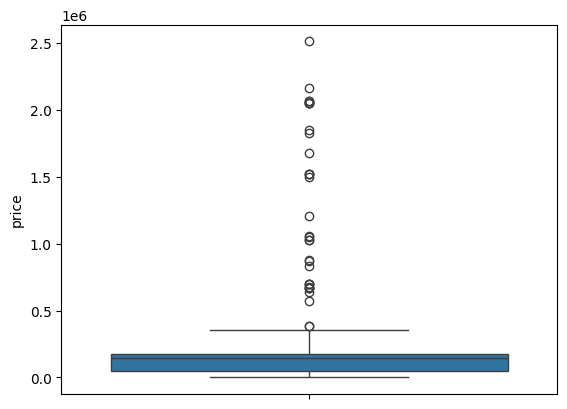

In [6]:
df = df[df['price'] < 33800995.000]
print(df.describe())
sns.boxplot(df['price'])

In [7]:
df[df['price'] > 300000].sort_values('price', ascending=False)

# сколько контейнеров, объем контейнера. вес контейнера, расчет с привязкой к валюте или еще чему то, ценность груза, вид контейнера - холодильник, цистерна дрр

,distance,own_container,complect_send,container_train,transportation_type,days,price
594,9274,0,0,1,3,22,2510946
1458,10388,0,0,1,3,21,2162284
916,9416,0,0,1,1,23,2067167
701,9416,0,0,1,1,23,2067167
915,9278,0,0,1,1,22,2050353
704,9278,0,0,1,1,22,2050353
917,9263,0,0,1,1,22,2048400
703,9263,0,0,1,1,22,2048400
72,9416,0,0,1,1,23,1848431
70,9263,0,0,1,1,22,1829664


In [8]:
df[df['price'] > 300000][['distance', 'days', 'price']].corr()

,distance,days,price
distance,1.000,0.719,0.641
days,0.719,1.000,0.277
price,0.641,0.277,1.000


In [9]:
df = df[df['price'] < 300000]
df.describe()

,distance,own_container,complect_send,container_train,transportation_type,days,price
count,1534.000,1534.000,1534.000,1534.000,1534.000,1534.000,1534.000
mean,4684.228,0.026,0.376,0.257,2.788,16.439,129739.551
std,2115.117,0.159,0.485,0.437,0.609,6.410,64042.769
min,18.000,0.000,0.000,0.000,1.000,4.000,1000.000
25%,3610.500,0.000,0.000,0.000,3.000,12.000,45948.000
50%,4290.000,0.000,0.000,0.000,3.000,17.000,141916.000
75%,4905.000,0.000,1.000,1.000,3.000,18.000,176707.750
max,10645.000,1.000,1.000,1.000,4.000,41.000,295637.000


## Split df to train and test

In [10]:
X, y = df.drop('price', axis=1), df['price']

# split df into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RAND_ST)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1150, 6) (1150,) (384, 6) (384,)


In [11]:
# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# X_train
# y_train

In [12]:
X.select_dtypes(exclude='object').columns

Index(['distance', 'own_container', 'complect_send', 'container_train',
       'transportation_type', 'days'],
      dtype='object')

## Violinplot for num col

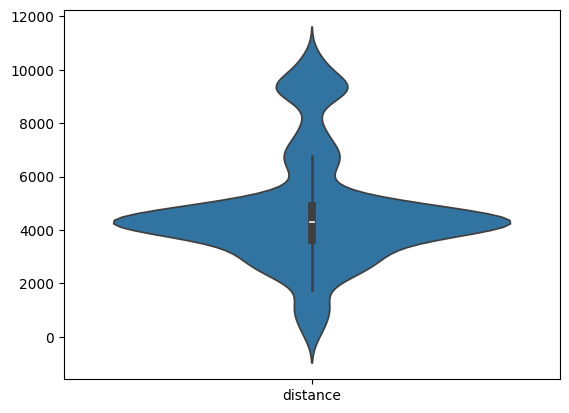

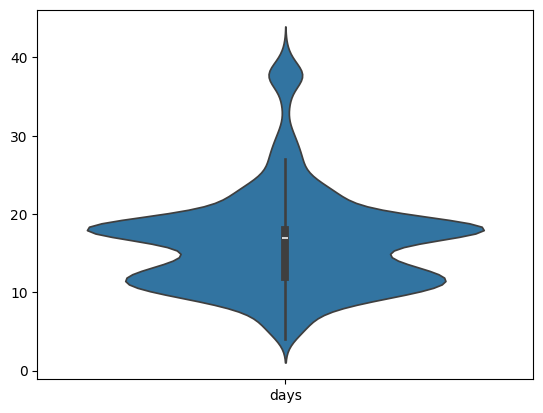

In [13]:
num_col = ['distance', 'days']

for i in df[num_col]:
    sns.violinplot(data = df[[i]])
    plt.show()

## Make pipeline

In [14]:

    num_col = ['distance', 'days']

    cat_col = ['own_container', 'complect_send', 'container_train',
        'transportation_type']
    # transformer for numeric col
    num_transformer = skl_pipeline(
        steps=[
            #transform
            (
                'power',
                PowerTransformer()
            )
        ]
    )


    # transformer for categorical col
    cat_transformer = skl_pipeline(
        steps=[
            (
                'ohe',
                OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False) # drop = 'if_binary' if cat will not change
            )
        ]
    )


    # make preprocessor
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('num_transformer', num_transformer, num_col),
            ('cat_transformer', cat_transformer, cat_col)
        ]
    )

    # make pipe model
    pipe_xgbr = skl_pipeline(steps=[
        
        (
            'preprocessor',
            preprocessor
        ),
        #model
        (
            'model_xgbr',
            xgb.XGBRegressor(random_state=RAND_ST)
        )
    ])

In [15]:
preprocessor.fit(X_train, y_train)
preprocessor.transform(X_train)

,num_transformer__distance,num_transformer__days,cat_transformer__own_container_1,cat_transformer__complect_send_1,cat_transformer__container_train_1,cat_transformer__transportation_type_2,cat_transformer__transportation_type_3,cat_transformer__transportation_type_4
582,-2.754,-1.378,0.000,0.000,1.000,0.000,1.000,0.000
1014,-0.188,0.398,0.000,0.000,0.000,0.000,1.000,0.000
365,-0.626,-0.882,0.000,1.000,0.000,0.000,1.000,0.000
370,-0.598,-0.882,0.000,1.000,0.000,0.000,1.000,0.000
890,-0.188,0.398,0.000,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...
571,1.089,2.417,0.000,0.000,0.000,1.000,0.000,0.000
419,0.004,-0.086,0.000,1.000,0.000,0.000,1.000,0.000
675,-0.868,-0.882,0.000,0.000,1.000,0.000,1.000,0.000
213,-1.060,-1.120,0.000,1.000,0.000,0.000,1.000,0.000


## Hyperparameter tuning

In [16]:
# add hyper from tree 


def hyper_opt(trial):
    parameters_xgbr = {
        'model_xgbr__learning_rate': trial.suggest_float('model_xgbr__learning_rate', 0.01, 0.6), # alias for eta
        'model_xgbr__min_split_loss': trial.suggest_int ('model_xgbr__min_split_loss', 0, 250000),    # alias for gamma
        'model_xgbr__max_depth': trial.suggest_int('model_xgbr__max_depth', 1, 100),
        'model_xgbr__min_child_weight': trial.suggest_int('model_xgbr__min_child_weight', 1, 20),
        'model_xgbr__subsample': trial.suggest_float('model_xgbr__subsample', 0.5, 1),
        'model_xgbr__colsample_bytree': trial.suggest_float('model_xgbr__colsample_bytree', 0.5, 1),
        'model_xgbr__reg_lambda': trial.suggest_int('model_xgbr__reg_lambda', 0, 200),
        'model_xgbr__reg_alpha': trial.suggest_int('model_xgbr__reg_alpha', 0, 100),    #???
        'model_xgbr__n_estimators': trial.suggest_int('model_xgbr__n_estimators', 5, 2000),
        'model_xgbr__max_leaves': trial.suggest_int('model_xgbr__max_leaves', 2, 100)
    }
    
    num_col = ['distance', 'days']

    cat_col = ['own_container', 'complect_send', 'container_train',
        'transportation_type']
    # transformer for numeric col
    num_transformer = skl_pipeline(
        steps=[
            #transform
            (
                'power',
                PowerTransformer()
            )
        ]
    )


    # transformer for categorical col
    cat_transformer = skl_pipeline(
        steps=[
            (
                'ohe',
                OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
            )
        ]
    )


    # make preprocessor
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('num_transformer', num_transformer, num_col),
            ('cat_transformer', cat_transformer, cat_col)
        ]
    )

    # make pipe model
    pipe_xgbr = skl_pipeline(steps=[
        
        (
            'preprocessor',
            preprocessor
        ),
        #model
        (
            'model_xgbr',
            xgb.XGBRegressor(random_state=RAND_ST)
        )
    ])

    pipe_xgbr.set_params(**parameters_xgbr) #разименование
    
    return cross_val_score(pipe_xgbr, X_train, y_train, scoring='neg_mean_squared_error').mean() #neg mse???
    # pipe_xgbr.fit(X_train, y_train)
    # print(mean_squared_error(pipe_xgbr.predict(X_train), y_train))
    # return mean_squared_error(pipe_xgbr.predict(X_train), y_train)
    

In [17]:
study = optuna.create_study(direction='maximize') #maximize
study.optimize(hyper_opt, n_trials=100)

[I 2023-12-02 13:10:28,688] A new study created in memory with name: no-name-370ce4a8-33d8-4a83-b4cf-f4fcf7f3a8f5
[I 2023-12-02 13:10:31,293] Trial 0 finished with value: -658050083.3979561 and parameters: {'model_xgbr__learning_rate': 0.5350446258019728, 'model_xgbr__min_split_loss': 166029, 'model_xgbr__max_depth': 91, 'model_xgbr__min_child_weight': 8, 'model_xgbr__subsample': 0.8170926635243025, 'model_xgbr__colsample_bytree': 0.8206630796779282, 'model_xgbr__reg_lambda': 193, 'model_xgbr__reg_alpha': 53, 'model_xgbr__n_estimators': 847, 'model_xgbr__max_leaves': 75}. Best is trial 0 with value: -658050083.3979561.
[I 2023-12-02 13:10:32,928] Trial 1 finished with value: -760487246.7831943 and parameters: {'model_xgbr__learning_rate': 0.0753159931131614, 'model_xgbr__min_split_loss': 128658, 'model_xgbr__max_depth': 46, 'model_xgbr__min_child_weight': 10, 'model_xgbr__subsample': 0.513879431148558, 'model_xgbr__colsample_bytree': 0.7298349978648512, 'model_xgbr__reg_lambda': 72, 'm

{'model_xgbr__learning_rate': 0.11576696040986036, 'model_xgbr__min_split_loss': 227308, 'model_xgbr__max_depth': 41, 'model_xgbr__min_child_weight': 1, 'model_xgbr__subsample': 0.8533280965682518, 'model_xgbr__colsample_bytree': 0.8658108780536792, 'model_xgbr__reg_lambda': 165, 'model_xgbr__reg_alpha': 85, 'model_xgbr__n_estimators': 1306, 'model_xgbr__max_leaves': 33}


/tmp/ipykernel_37453/1373939319.py:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


-615316024.2040112

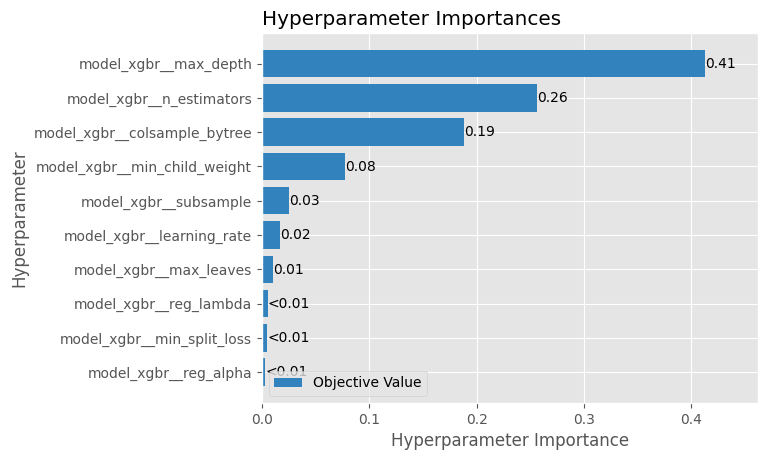

In [18]:
print(study.best_params)

plot_param_importances(study);
study.best_value

In [19]:
pipe_xgbr.set_params(**study.best_params)
pipe_xgbr.fit(X_train, y_train)
pd.DataFrame(pipe_xgbr.predict(X_train)).describe()
mean_squared_error(y_train, pipe_xgbr.predict(X_train))/y_train.shape
mean_absolute_error(y_train, pipe_xgbr.predict(X_train))/y_train.shape

array([6.8927011])

## Mlflow model save

In [20]:
# start server 
mlflow.set_tracking_uri='http://127.0.0.1:5000'

In [35]:
# Set our tracking server uri for logging
# mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("XGBR 4")

<Experiment: artifact_location='file:///home/pmu/zet/obs-h/Skills/Data%20Science/Data%20Scientist%20Full-Stack/exercises/practice/mlruns/555592421686817878', creation_time=1701359199067, experiment_id='555592421686817878', last_update_time=1701359199067, lifecycle_stage='active', name='XGBR 4', tags={}>

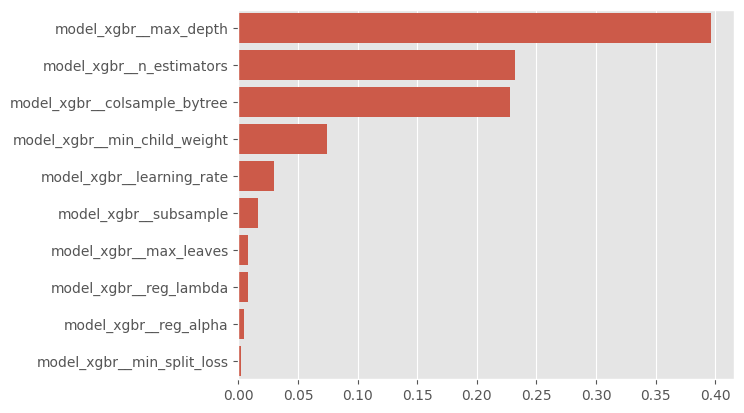

In [36]:
hyperparams = optuna.importance.get_param_importances(study)
sns.barplot(y=hyperparams.keys(), x=hyperparams.values())
plt.savefig('hyperparams.png')

In [37]:
# Start an MLflow run
with mlflow.start_run(run_name='xgbr_price_2000_estimate_max_lives'):
    # Log the hyperparameters
    mlflow.log_params(study.best_params)
    pipe_xgbr.set_params(**study.best_params)
    pipe_xgbr.fit(X_train, y_train)
    predict_test  = pipe_xgbr.predict(X_test)
    metrics = {
        'mse_cv':study.best_value / len(y_train) * 0.8, # if cv = 5
        'mae': mean_absolute_error(y_test, predict_test) / len(y_test),
        'median_abs_error': abs(y_test - predict_test).median(),
        'mean_abs_error': abs(y_test - predict_test).mean(),
        'median_error': (abs(y_test - predict_test)/ y_test).median(),
        'mean_error': (abs(y_test - predict_test) / y_test).mean()
    } 
    mlflow.log_artifact('hyperparams.png') 
    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(pipe_xgbr, 'xgbr_price_2000_estimate_max_lives')

/home/pmu/zet/obs-h/Progects_od/transport/.conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/pmu/zet/obs-h/Progects_od/transport/.conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Model analysis

In [23]:
print(f'RMSE = {mean_squared_error(y_test, pipe_xgbr.predict(X_test), squared=False) / y_test.shape}')
print(f'MAE = {mean_absolute_error(y_test, pipe_xgbr.predict(X_test)) / y_test.shape}')

RMSE = [74.94446954]
MAE = [36.13070517]


0.13336423148237564 0.018671190602565946


<Axes: >

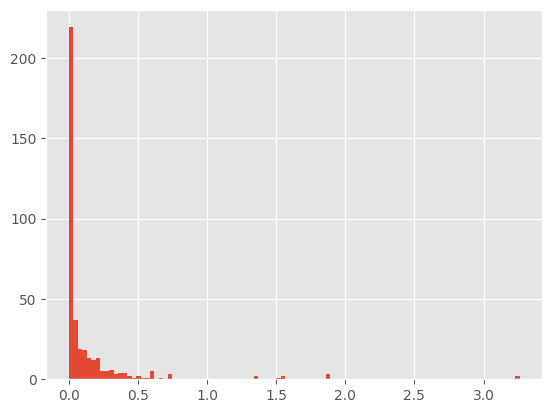

In [24]:
error_abs = (abs(pipe_xgbr.predict(X_test) - y_test)) / y_test
print(error_abs.mean(), error_abs.median())
error_abs.hist(bins=100)

In [25]:
(pd.DataFrame(pipe_xgbr.predict(X_test))).describe()

,0
count,384.000
mean,133877.922
std,60163.703
min,16796.334
25%,79838.422
50%,147587.273
75%,173604.391
max,292253.938


array([[<Axes: title={'center': '0'}>]], dtype=object)

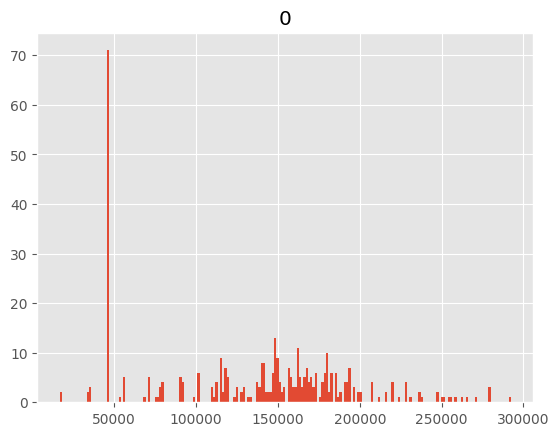

In [26]:
(pd.DataFrame(pipe_xgbr.predict(X_test))).hist(bins=200)

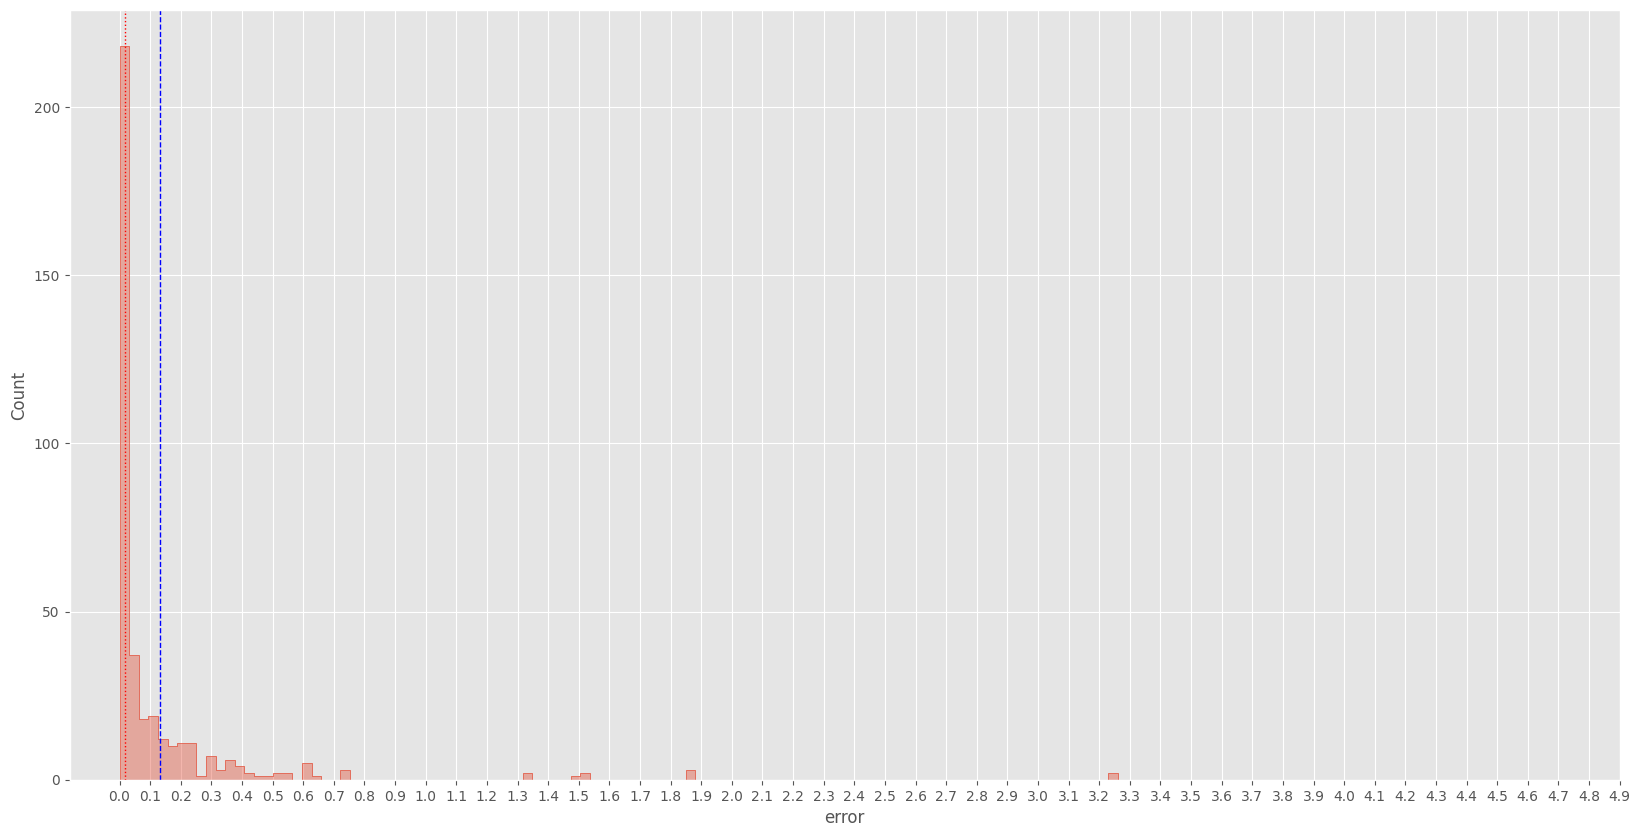

In [27]:
abs_error = abs(y_test - pipe_xgbr.predict(X_test)) / y_test


# sns mean + median  mlflow fig 

plt.figure(figsize=(20, 10))
sns.histplot(abs_error, alpha=0.4,  element="step")
plt.xticks(np.arange(0, 5, 0.1))
plt.axvline(x=abs_error.mean(), color='b', ls='--', lw=1, label='Mean value of abs error')
plt.axvline(x=abs_error.median(), color='r', ls=':', lw=1, label='Median value of abs error')
plt.xlabel('error')
plt.show()

<Axes: ylabel='price'>

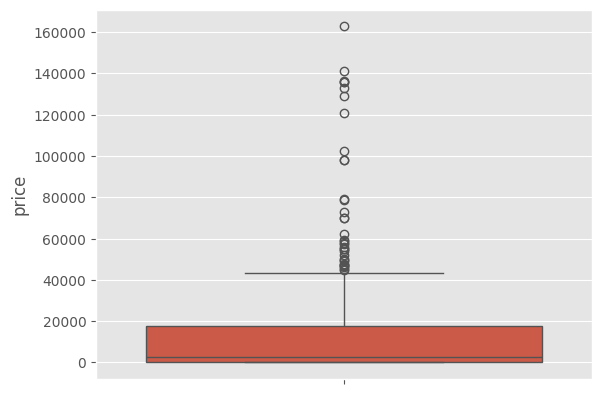

In [28]:
sns.boxplot(pd.Series(abs(y_test - pipe_xgbr.predict(X_test))))

In [29]:
pipe_xgbr.predict(X_test)

array([179031.58 , 169882.81 ,  34546.555, 149143.84 , 129089.52 ,
       188839.25 , 137133.22 , 115105.266, 228823.34 ,  90926.86 ,
       139675.31 , 228823.34 ,  46101.71 , 182549.77 , 118209.73 ,
       193120.52 , 175533.39 , 179031.58 , 147918.95 , 179934.22 ,
        46101.71 , 182840.88 ,  46101.71 ,  46101.71 , 146789.19 ,
       262966.   , 194121.47 , 278859.9  ,  46101.71 , 150995.25 ,
       163135.03 ,  79838.42 ,  46101.71 , 148925.27 ,  46101.71 ,
       182840.88 ,  46101.71 , 151043.19 ,  46101.71 , 228823.34 ,
       117699.305, 194121.47 ,  46101.71 , 150042.38 , 119679.445,
       114790.28 , 196185.47 , 119679.445,  46101.71 ,  46101.71 ,
       237012.66 , 150074.98 ,  46101.71 , 251653.3  ,  46101.71 ,
       170753.36 , 117953.52 , 118209.73 , 237012.66 , 122870.46 ,
        46101.71 , 211291.8  ,  46101.71 , 254643.97 ,  46101.71 ,
        16796.334, 192953.58 , 230929.42 , 178800.56 , 139861.03 ,
        46101.71 , 256232.38 , 185407.77 , 220038.77 , 132790.

## Importances

In [30]:
pipe_xgbr['model_xgbr'].feature_importances_

array([0.1739659 , 0.1179296 , 0.05528029, 0.33796647, 0.12992106,
       0.04239637, 0.12250995, 0.02003038], dtype=float32)

In [31]:
pipe_xgbr['preprocessor'].get_feature_names_out()

array(['num_transformer__distance', 'num_transformer__days',
       'cat_transformer__own_container_1',
       'cat_transformer__complect_send_1',
       'cat_transformer__container_train_1',
       'cat_transformer__transportation_type_2',
       'cat_transformer__transportation_type_3',
       'cat_transformer__transportation_type_4'], dtype=object)

<Axes: xlabel='importance', ylabel='name'>

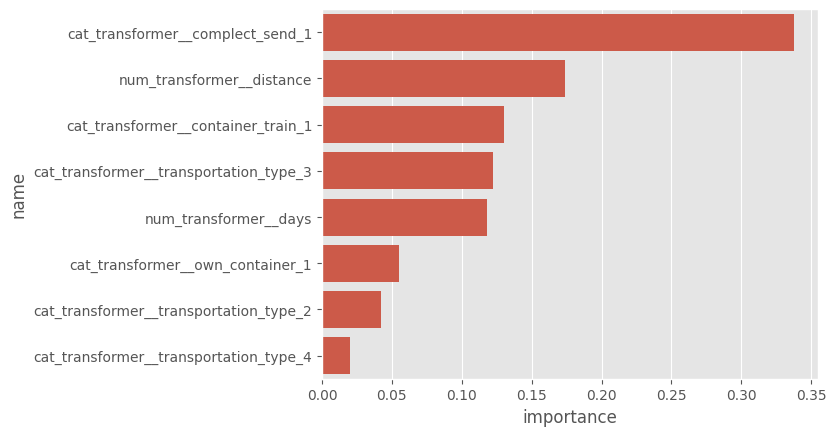

In [34]:
# Importing the required data into a Pandas DataFrame
importance = pd.DataFrame({
    'name': pipe_xgbr['preprocessor'].get_feature_names_out(), # Get names of the features used in the model
    'importance': pipe_xgbr['model_xgbr'].feature_importances_ # Get the importance of each feature
})

# Sorting the data based on the importance of each feature
importance.sort_values('importance', ascending=False, inplace=True)

# Plotting a barplot of the feature importances using seaborn
sns.barplot(data=importance, y='name', x='importance')